In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

In [2]:
raw_data = pd.read_csv("Stars.csv")

In [3]:
df = raw_data.copy()
df

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,5
236,30839,834042.000000,1194.0000,-10.63,Blue,O,5
237,8829,537493.000000,1423.0000,-10.73,White,A,5
238,9235,404940.000000,1112.0000,-11.23,White,A,5


### Dataset Info:
This is a dataset consisting of several features of stars.

Some of them are:

Absolute Temperature (in K)

Relative Luminosity (L/Lo)

Relative Radius (R/Ro)

Absolute Magnitude (Mv)

Star Color (white,Red,Blue,Yellow,yellow-orange etc)

Spectral Class (O,B,A,F,G,K,,M)

Star Type **(Red Dwarf=0, Brown Dwarf=1, White Dwarf=2, Main Sequence=3 , SuperGiants=4, HyperGiants=5)**

Let's rename some columns to make more sense

In [4]:
df.rename(columns={"L":"Luminosity","R":"Radius","A_M":"Magnitude"}, 
                inplace= True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   Luminosity      240 non-null    float64
 2   Radius          240 non-null    float64
 3   Magnitude       240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


No null values so, thank you very much.

#### Let's check the distribution of the target "Type" and other categorical features

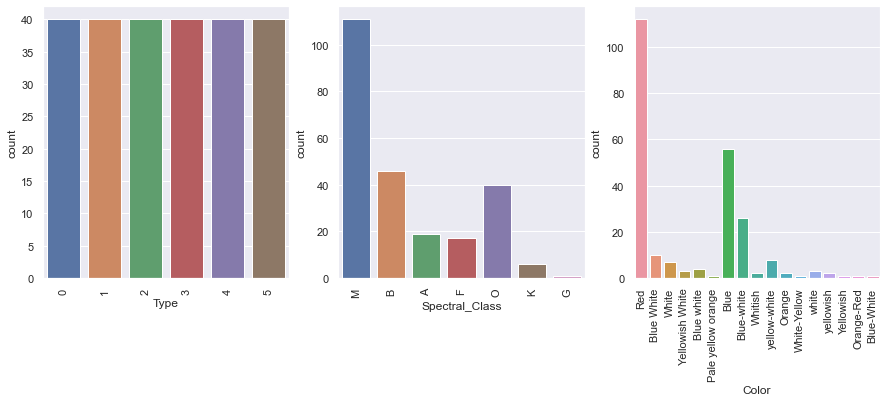

In [6]:
cat_var=["Type","Spectral_Class","Color"]

plt.figure(figsize=(15,5))
for i, col in enumerate(cat_var):
    ax = plt.subplot(1,len(cat_var), i+1)
    sns.countplot(data=df,x=col,ax=ax)
    plt.xticks(rotation=90)

So there are equal amounts of Star Types.<br>
**M** in **Spectral class** and **Red** in **Color** seem to have the same number.<br> 
Are those related??? Let's check that with  crossplot.<br>
First let's get the actual number of the unique classes in the categorical features.<br>

In [7]:
for i in cat_var:
    print(df[i].value_counts())
    print("\n")

0    40
1    40
2    40
3    40
4    40
5    40
Name: Type, dtype: int64


M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral_Class, dtype: int64


Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
white                   3
Yellowish White         3
yellowish               2
Whitish                 2
Orange                  2
White-Yellow            1
Pale yellow orange      1
Yellowish               1
Orange-Red              1
Blue-White              1
Name: Color, dtype: int64




Blue-white, Blue White, Blue white, White Blue... Lol<br>
Let's chop all that into one color<br>
And any other colors that seem or are actually similar <br>

After reading this article, and looking  at what we have in our data, I have chosen to use these six color types.<br>
From hottest to coldest we have.
- Blue
- Blue White
- White
- Yellow
- Orange
- Red

So let's _rewrite the stars_

In [8]:
df["Color"].replace(["Blue-white","Blue-White","Blue white", "White Blue","Yellowish White","yellow-white","yellowish","White-Yellow","Whitish","white","Pale yellow orange",
           "Orange-Red"],["Blue White","Blue White","Blue White","Blue White","Yellowish","Yellowish","Yellowish","Yellowish","White","White","Orange","Orange",],inplace=True)

Let's check that again

In [9]:
for i in cat_var:
    print(df[i].value_counts())
    print("\n")

0    40
1    40
2    40
3    40
4    40
5    40
Name: Type, dtype: int64


M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral_Class, dtype: int64


Red           112
Blue           56
Blue White     41
Yellowish      15
White          12
Orange          4
Name: Color, dtype: int64




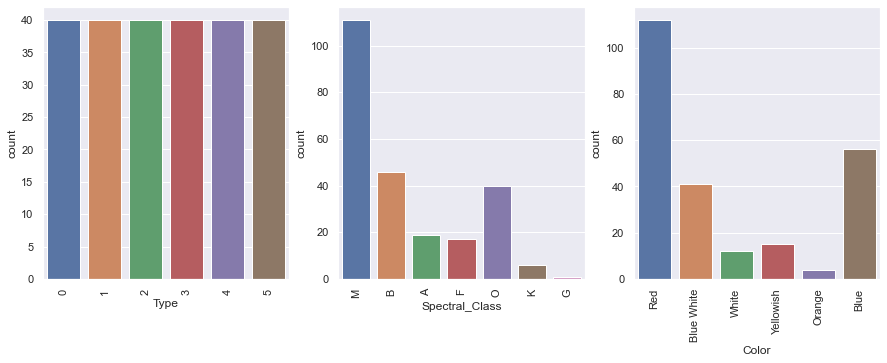

In [10]:
# Redo count plot of categorical features
cat_var=["Type","Spectral_Class","Color"]

plt.figure(figsize=(15,5))
for i, col in enumerate(cat_var):
    ax = plt.subplot(1,len(cat_var), i+1)
    sns.countplot(data=df,x=col,ax=ax)
    plt.xticks(rotation=90)

Ok now let's do the crosstab thingy

In [11]:
pd.crosstab(df["Color"],df["Spectral_Class"],margins=True).style.background_gradient(cmap='YlOrRd')

Spectral_Class,A,B,F,G,K,M,O,All
Color,,,,,,,,
Blue,0,16,0,0,0,0,40,56
Blue White,12,29,0,0,0,0,0,41
Orange,0,0,1,0,2,1,0,4
Red,0,0,0,1,1,110,0,112
White,7,1,4,0,0,0,0,12
Yellowish,0,0,12,0,3,0,0,15
All,19,46,17,1,6,111,40,240


So 110 of our 111 M spectral class are Red in colour imagine the effect of that on a model...<br>
Don't think we'd need both when building a model...<br>
I hinted earlier that Temperature is correlated to Color, it is important to note that Spectral class is also correlated to color. _A theory we would test soon_  <br>
Let's do 2 more crosstabs, each of them against Type so we'd know which seems less.

In [12]:
pd.crosstab(df["Type"],df["Color"],margins=True).style.background_gradient(cmap='YlOrRd')

Color,Blue,Blue White,Orange,Red,White,Yellowish,All
Type,,,,,,,
0,0,0,0,40,0,0,40
1,0,0,0,40,0,0,40
2,13,14,1,0,8,4,40
3,5,21,1,0,2,11,40
4,31,0,0,9,0,0,40
5,7,6,2,23,2,0,40
All,56,41,4,112,12,15,240


All Type 1 and 2 are Red, is that a **_Red Flag_**?...
Also almost 80% of Type 4 is Blue...
The rest seem to be spread out _ok_ enough.

Also Remember star Type 0 and 1 are Red_dwarf and Brown_Dwarf respectively. So the colour in the names give a hint. For star Type 2 it's called White Dwarf... 14 are a variation of white and blue, 13 are tagged as blue and 8 are white. So the colour naming is still in effect to some extent here too.

In [13]:
pd.crosstab(df["Type"],df["Spectral_Class"],margins=True).style.background_gradient(cmap='YlOrRd')

Spectral_Class,A,B,F,G,K,M,O,All
Type,,,,,,,,
0,0,0,0,0,0,40,0,40
1,0,0,0,0,0,40,0,40
2,7,24,9,0,0,0,0,40
3,10,13,8,0,4,0,5,40
4,0,2,0,0,0,9,29,40
5,2,7,0,1,2,22,6,40
All,19,46,17,1,6,111,40,240






<br><br><br><br>
In trying to prove their correlation, I will create a new df "df_alt" and assign numeric values to Color and Spectral class. Then do a correlation plot.
<br><br><br><br>





In [14]:
df_alt = df.copy()

In [15]:
# Use a dictionary for of replace
df_alt["Color"].replace({"Red":0,"Orange":1,"Yellowish":2,"White":3,"Blue White":4,"Blue":5},inplace=True)
# List method is easier to type going back to that
df_alt["Spectral_Class"].replace(['M', 'B', 'A', 'F', 'O', 'K', 'G'],[0,1,2,3,4,5,6],inplace=True)

In [16]:
df_alt

,Temperature,Luminosity,Radius,Magnitude,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,0,0,0
1,3042,0.000500,0.1542,16.60,0,0,0
2,2600,0.000300,0.1020,18.70,0,0,0
3,2800,0.000200,0.1600,16.65,0,0,0
4,1939,0.000138,0.1030,20.06,0,0,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,4,5
236,30839,834042.000000,1194.0000,-10.63,5,4,5
237,8829,537493.000000,1423.0000,-10.73,3,2,5
238,9235,404940.000000,1112.0000,-11.23,3,2,5


<AxesSubplot:>

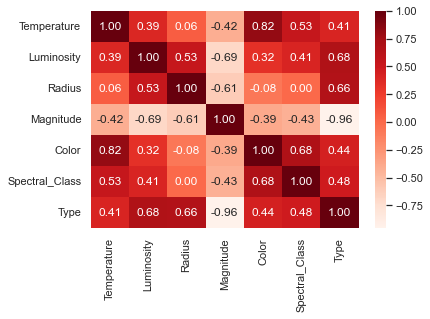

In [17]:
sns.heatmap(df_alt.corr(), center=0, cmap='Reds',annot=True, fmt=".2f")

I used code from _this_ notebook to extract the output below.

Magnitude and Type = -0.96<br>
Temperature and Color = 0.82<br>
Luminosity and Magnitude = -0.69<br>
Color and Spectral_Class = 0.68<br>
Luminosity and Type = 0.68<br>
Radius and Type = 0.66<br>
Radius and Magnitude = -0.61<br>
Temperature and Spectral_Class = 0.53<br>
Luminosity and Radius = 0.53<br>

## Continuos Features

A little EDA on the continuos features

In [25]:
cont_features = ['Temperature', 'Luminosity', 'Radius', 'Magnitude']

First let's see the distribution of their values with a violin plot.

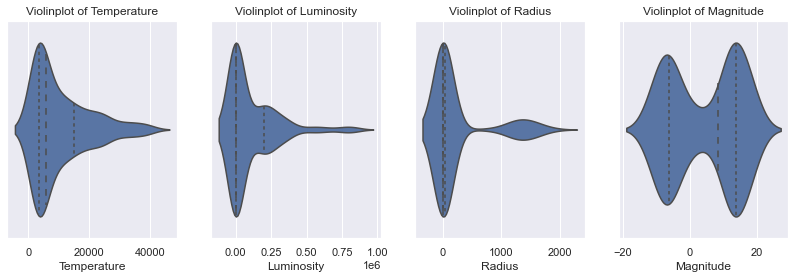

In [30]:
plt.figure(figsize=(14,4))
for i, col in enumerate(cont_features):
    ax = plt.subplot(1, len(cont_features), i+1)
    sns.violinplot(data=df, x=col, ax=ax,inner="quartile")
    ax.set_title(f"Violinplot of {col}")

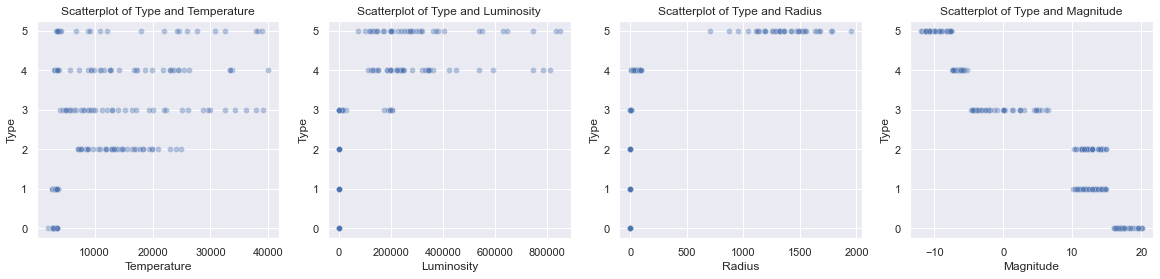

In [37]:
plt.figure(figsize=(20,4))
for i, col in enumerate(cont_features):
    ax = plt.subplot(1, len(cont_features), i+1)
    sns.scatterplot(data=df, x=col, y="Type", ax=ax,palette = "muted",alpha=.4)
    ax.set_title(f"Scatterplot of Type and {col}")

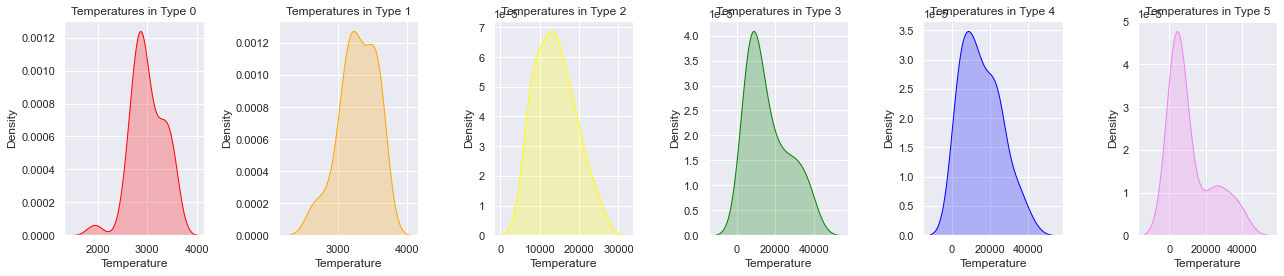

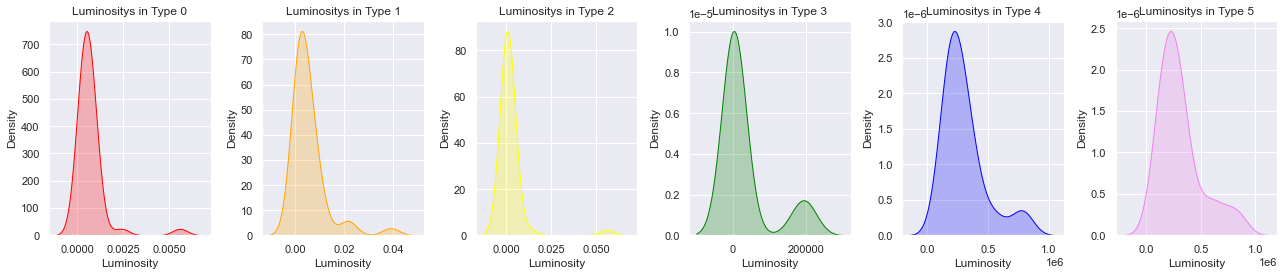

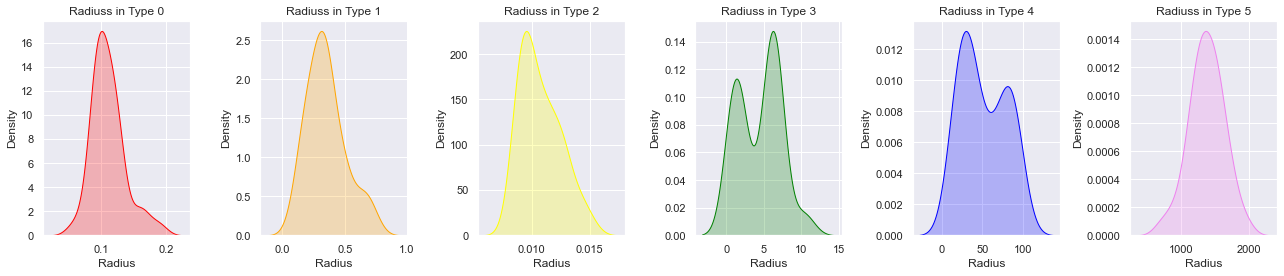

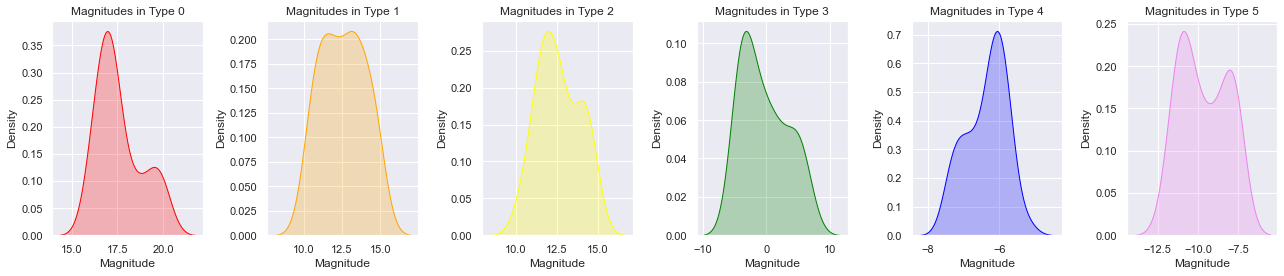

In [32]:
for i in cont_features:
    f,ax=plt.subplots(1,6,figsize=(18,4))
    sns.kdeplot(df[df['Type']==0][i],ax=ax[0],shade=True,color="red")
    ax[0].set_title(f'{i}s in Type 0')
    sns.kdeplot(df[df['Type']==1][i],ax=ax[1],shade=True,color="orange")
    ax[1].set_title(f'{i}s in Type 1')
    sns.kdeplot(df[df['Type']==2][i],ax=ax[2],shade=True,color="yellow")
    ax[2].set_title(f'{i}s in Type 2')
    sns.kdeplot(df[df['Type']==3][i],ax=ax[3],shade=True,color="green")
    ax[3].set_title(f'{i}s in Type 3')
    sns.kdeplot(df[df['Type']==4][i],ax=ax[4],shade=True,color="blue")
    ax[4].set_title(f'{i}s in Type 4')
    sns.kdeplot(df[df['Type']==5][i],ax=ax[5],shade=True,color="violet")
    ax[5].set_title(f'{i}s in Type 5')
    plt.tight_layout()

Summing up Deductions from plots above
Majority of the stars have a temperature of 2400 and 4000.
Majority of luminosity values hover around 0 until star type 3 when we begin to have really large values.
Majority of star radii are between 0 and 1 with star type 2 having the smallest radii.
Magnitude is the only one with values _"inversly proprtional"_ to star type.